In [1]:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filePath = "./Speed_Dating_Data.csv" 
df = pd.read_csv(filePath)
df.iid = df.iid.astype(float)
df.pid = df.pid.astype(float)

FIGURE_SIZE = (15, 8)

# Intro
This notebook is an exploration of speed dating data by Shreyas Kadekodi and Saurabh Totey for CSCI 3022 at CU Boulder. We used this data to try and confirm 'common sense' as well try and explore other interesting possible correlations. This notebook is available on GitHub [here](https://github.com/Kadekool/Speed-Dating-Exploration).

## Data Format
All of the data was obtained from https://www.kaggle.com/annavictoria/speed-dating-experiment. In general, the data is in a CSV where each row corresponds to a date. If there is data tied to an individual, it is generally repeated in future rows but there are many omissions from the data set. Each date therefore corresponds to 2 rows in the dataset: one for each partner. The way that 'matches' work in this dataset is that if person A matches with person B, then that means that person B must have also matched with person A.


## Question: How many matches did each person get?
For this question, we simply wanted to visualize how many matches each individual got. Each person has a unique iid, and we traversed the file in order to get the number of matches each individual recieved. The code is below.

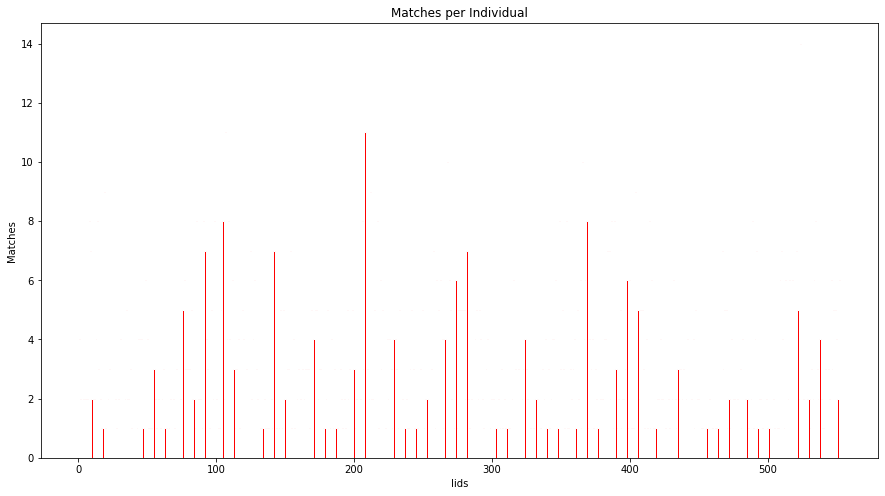

In [18]:
iids = pd.unique(df.iid)

# Assigns every unique person (by their iid) an attractiveness score based on the average of what their partners rated them
matchesPerPerson=[[0] for _ in range (len(iids))]

j=0
for subjectOfInterest in iids:
    individualMatch = df[(df.iid == subjectOfInterest) & (df.pid.notna())]  
    matchSuccessRate = len(individualMatch[individualMatch.match == 1])
    matchesPerPerson[j] = matchSuccessRate
    j+=1
    
plt.figure(figsize=FIGURE_SIZE)
plt.bar(iids,matchesPerPerson, color="red", edgecolor="white")
plt.title("Matches per Individual")
plt.xlabel("Iids")
plt.ylabel("Matches")
plt.show()

## Question: Are matches more common for people with similar attractivenesses?
For this question, we wanted to know how common it was for people to match with others who were 'out of their league'. To tackle this question, we assigned each person an attractiveness score. A person's attractiveness score was the average attractiveness rating they were given by their partners out of 10. Then, we looked at all couples that matched and took the difference in their attractiveness score. To answer this question, we plotted a histogram of the attractiveness differences for those who matched. The code is below.

In [ ]:
iids = pd.unique(df.iid)

# Assigns every unique person (by their iid) an attractiveness score based on the average of what their partners rated them
personToAttractiveness = {}
for subjectOfInterest in iids:
    attractiveness = statistics.mean(df[(df.iid == subjectOfInterest) & (df.attr_o.notna())].attr_o)
    personToAttractiveness[subjectOfInterest] = attractiveness

# Constructs a dictionary of pairs (tuple of iid and pid) to whether they matched
pairToDidMatch = {}
rowsWithPairs = df[df.iid.notna() & df.pid.notna()]
for iid in iids:
    for pid in rowsWithPairs[rowsWithPairs.iid == iid].pid:
        if (pid, iid) in pairToDidMatch:
            # Asserts that if person A matches with person B, then person B has also matched with person A
            assert rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match == pairToDidMatch[(pid, iid)]
            continue
        pairToDidMatch[(iid, pid)] = rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match
        
# Gets all the differences of attractivenesses between people of all pairings and also collects whether the pair matched
attractivenessDifferences = [abs(personToAttractiveness[pair[0]] - personToAttractiveness[pair[1]]) for pair in pairToDidMatch.keys()]
correspondingDidMatch = list(pairToDidMatch.values())

# Gets the attractivness difference of people who matched
attractivenessDifferencesOfMatchers = []
for i in range(len(correspondingDidMatch)):
    if correspondingDidMatch[i] == 0:
        continue
    attractivenessDifferencesOfMatchers.append(attractivenessDifferences[i])

# Plots a density histogram of people who matched where the bins are of their attractiveness difference
plt.figure(figsize=FIGURE_SIZE)
plt.hist(attractivenessDifferencesOfMatchers, density=True, color="red", edgecolor="white")
plt.title("Ratio of Matches vs. Difference in Attractiveness")
plt.xlabel("Attractiveness Difference")
plt.ylabel("Ratio of Matches")
plt.show()

### Analysis
The histogram seems to affirm the idea that the larger the difference in attractiveness is between partners, the more unlikely the partners are to have matched. Most matches happened between those who had less than 1 unit of attractiveness difference. However, that isn't to say that no matches hapenned with large attractiveness differences. One important caveat of the above histogram is that it is a density histogram only of those people that matched. The histogram does not say that if you have 0 difference in attractiveness, then you have a ~0.35 probability of matching: instead, the histogram says that if you have matched, you have a ~0.35 probability of having an attractiveness difference near 0 with your partner. These statements are related, but not necessarily the same. Another caveat is that the histogram is a density histogram by area, not by counts: the sum of the areas of the bars is 1, so the probabilities for any attractiveness difference is the width of its bar times its height.

## Question: Do attractive people match more?
This was another 'common sense' question we wanted to affirm. Common experience would dictate that attractive people are more likely to get matches while dating. To tackle this problem, we took each person, found out the ratio of how many times they matched, and plotted that against their attractiveness level from the previoius question.

In [ ]:
# Gets a list of attractivenesses of all people and calculates the proportion of matches they made
attractivenesses = list(personToAttractiveness.values())
correspondingMatchRate = []
for subjectOfInterest in iids:
    rowsOfPerson = df[(df.iid == subjectOfInterest) & (df.pid.notna())]
    matchSuccessRate = len(rowsOfPerson[rowsOfPerson.match == 1]) / len(rowsOfPerson)
    correspondingMatchRate.append(matchSuccessRate)

# Plots a scatter plot of attractiveness rating and match rate with the corresponding linear regression
plt.figure(figsize=FIGURE_SIZE)
plt.plot(attractivenesses, correspondingMatchRate, "or")
plt.title("Match Rate vs. Attractiveness Rating")
plt.xlabel("Attractiveness Rating")
plt.ylabel("Match Rate")
plt.show()

### Analysis
This data generally seems to affirm that more attractive people can match more. However, there were quite a few 0% match rates across all attractiveness levels. Something this dataset doesn't show is the reason why a match rate is what it is. It is possible that people didn't match because they were too picky, or because of their personality. On its own this graph only shows only one dimension of match rates. This graph is very noisy especially because there was a wide variety of match rates as each point was generated per person and there are probably many reasons for why a match happens or doesn't happen for each individual. Regardless, the general trend of this scatter plot can be seen by looking at the max rates of matching: the higher the attractiveness, the higher the max match rate. All data below the max seems to be more or less randomly distributed, but there isn't enough data to really tell.<br/>
In order to try and reduce the noise in this graph and only look at trends, all people were binned into attractiveness tiers (the floor of their attractiveness level), and the average match rate for each bin was plotted. A linear regression line was then added to try and confirm the trend.

In [ ]:
# Maps an attractiveness bin (all atractivenesses that are in the same 'group') to a list of match rates
bins = range(1, 11)
binToMatchRates = {binValue: [] for binValue in bins}
for i in range(len(attractivenesses)):
    attractiveness = attractivenesses[i]
    binValue = int(attractiveness)
    binToMatchRates[binValue].append(correspondingMatchRate[i])
    
# Removes empty values from the dictionary
for binValue in bins:
    if len(binToMatchRates[binValue]) == 0:
        del binToMatchRates[binValue]
        
# Linear regression
x = list(binToMatchRates.keys())
y = [statistics.mean(matchRates) for matchRates in list(binToMatchRates.values())]
linearRegressionCoefficients = np.polyfit(x, y, 1)
lineFunction = np.poly1d(linearRegressionCoefficients)
    
# Plots the average match rate for each attractiveness bin
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x, y, "ok", x, lineFunction(x), "-r")
plt.title("Average Match Rate vs. Attractiveness")
plt.xlabel("Attractiveness")
plt.ylabel("Average Match Rate")
plt.show()

# Prints the linear regression equation
print("Linear Regression Equation: y = {:10.5f}x + {:10.5f}.".format(*linearRegressionCoefficients))

### Analysis
This plot seems to more clearly show the trend of match rates: the higher one's attractiveness is, the higher their chances of matching. This plot is in-line with the previous plot, but a lot of the visual noise has been taken away by using bins and averages. The trend line seems to dictate that approximately for every 1 tier in imporovement of your attractiveness, your chance of matching increases by 5%. This isn't completely correct because the trend line predicts that someone with an attractiveness level of 2 out of 10 won't make any matches, but that probably isn't true. Interestingly, it seems like someone who is an 8 out of 10 in attractiveness has a massive match rate of around 30%. Furthermore, while the trend line would predict that someone with a perfect attractiveness level of 10 would have an approximately 40% match rate, there was no one rated 9 or above out of 10 in attractiveness on average and no one rated 1 in attractiveness either. This may be due to sample size, but it is also possible that attractiveness ratings aren't universal across all people (someone who appears to be a 1 out of 10 in attractiveness to person A might appear to be a 10 out of 10 to person B) and averages of attractiveness levels of people tend away from extremes.<br/>
Most importantly, while looking at this data, it is important to keep in mind that a lot of the details of matching have been boiled down to only one dependent factor: attractiveness. It is quite probable that there were more factors going into the decisions of matches than just attractiveness. These predictions based off of attractiveness are not absolute.

## Question: Does dating within your field improve your chances of matching?
This question came up while we were traversing the data set. Since the dates took place at universities, the general field of the individuals who participated was tracked. We wanted to see whether having the same general field led to greater match rates, given the pre-existing similarities that sharing a field creates. For context, 'homogenous', as used by the code, refers to individualssharing a field

In [ ]:
# Creates a mapping of iid to profession
individualToProfession = {iid: None for iid in iids}
for iid in iids:
    relevantRow = df[(df.iid == iid) & (df.field_cd.notna())]
    if len(relevantRow) != 0:
        individualToProfession[iid] = relevantRow.iloc[0].field_cd

# Deletes bad entries from the individualToProfession dictionary
# Ensures that each individual has a valid non-None profession
# Any individual with profession 18 ('other') is filtered out as well because 'other' is not a specific field
for iid in list(individualToProfession.keys()):
    if individualToProfession[iid] == None or individualToProfession[iid] == 18:
        del individualToProfession[iid]
        
# Goes through the pairs and checks whether they had the same profession (and if so, whether they matched)
# Instead of using a dictionary, a list is used because the profession numbers can be considered indices when shifted down by 1
# Homogeneous in this scenario means that both members of the pair have the same profession
professionToNumberOfHomogeneousDates = [0 for _ in range(17)]
professionToNumberOfHomogeneousMatches = [0 for _ in range(17)]
for pair in pairToDidMatch:
    if pair[0] not in individualToProfession or pair[1] not in individualToProfession:
        continue
    if individualToProfession[pair[0]] == individualToProfession[pair[1]]:
        profession = int(individualToProfession[pair[0]] - 1)
        professionToNumberOfHomogeneousMatches[profession] += pairToDidMatch[pair]
        professionToNumberOfHomogeneousDates[profession] += 1

titles = ['Law', 'Math', 'Psychology', 'Medical', 'Engineering', 'English', 'History', 'Business', 'Education', 'Sciences', 'Social Work', 'Undecided', 'PoliSci', 'Film', 'Arts', 'Languages', 'Architecture']

# Maps each profession to the rate at which homogeneous matches were made
# No mappings are made for professions without homogeneous dates
professionToMatchRate = {
    i: professionToNumberOfHomogeneousMatches[i] / professionToNumberOfHomogeneousDates[i]
    for i in range(len(professionToNumberOfHomogeneousDates))
    if professionToNumberOfHomogeneousDates[i] != 0
}

# Plots a bar chart
plt.figure(figsize=FIGURE_SIZE)
plt.bar([titles[i] for i in list(professionToMatchRate.keys())], list(professionToMatchRate.values()), color="red")
plt.axhline(y=statistics.mean(correspondingMatchRate), color="black")
plt.title("Proportion of Matches per Homogeneous Date vs. Field")
plt.xlabel("Field")
plt.ylabel("Proportion of Matches per Homogeneous Date")
plt.show()

### Analysis
For this graph, we analyzed the likelihood that someone matched with someone studying in their own field. For example, we wanted to see if a math major was more likely to match with another math major, with the black bar representing the general match rate. The graph does notseem to imply that sharing a field significantly changes the odds of getting a second date- while fields like law or pschology have far greater odds of a match than the general rate, which is marked by the black line, with match rates of above $\dfrac{1}{3}$,while people in the Math, History, and Film fields did not have any matches at all.

Despite this, we cannot rule out the idea that there may be a greater chance of matching with someone in the same or related field. It is very possible that other factors ended up dominating- perhaps all the math majors that day had some character flaw.  
